# Model Training

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2025-01-19 20:11:24.855501: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-19 20:11:25.020051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737288685.082976  317019 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737288685.100117  317019 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-19 20:11:25.251263: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## 1. 定义模型

In [2]:
# 定义模型
def get_dl_model_240():
    conv_x = [4, 1, 1, 1, 1, 1, 1, 1]
    conv_y = [1, 2, 2, 2, 2, 2, 2, 2]
    pool = [1, 2, 2, 2, 2, 2, 2, 2]
    filter_s = [1024, 1024, 128, 128, 128, 128, 128, 128]

    visible = layers.Input(shape=(4, 240, 1))
    x = visible

    for l in range(8):
        x = layers.ZeroPadding2D(padding=((0, 0), (0, conv_y[l] - 1)))(x)
        x = layers.Conv2D(filters=filter_s[l], kernel_size=(conv_x[l], conv_y[l]), strides=1, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(rate=0.2)(x)
        x = layers.AveragePooling2D(pool_size=(1, pool[l]))(x)

    flat = layers.Flatten()(x)

    y = tf.keras.layers.Reshape((4, 240))(visible)
    y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(y)
    y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(y)
    y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(y)
    flat = tf.keras.layers.concatenate([flat, y], axis=-1)

    hidden1 = layers.Dense(1024, activation='relu')(flat)
    drop1 = layers.Dropout(rate=0.2)(hidden1)
    output = layers.Dense(3, activation='softmax')(drop1)
    model = tf.keras.Model(inputs=visible, outputs=output)

    return model

## 2. 读取数据

In [3]:
def load_data(data_dir, label_dir):
    data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npy')])
    label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.npy')])
    
    data_list = [np.load(file) for file in data_files]
    label_list = [np.load(file) for file in label_files]
    
    data = np.stack(data_list)
    labels = np.stack(label_list)

    return data, labels

In [4]:
data_dir = 'simulation/out/S1U/numpy_data/seq'
label_dir = 'simulation/out/S1U/numpy_data/label'

data, labels = load_data(data_dir, label_dir)

In [5]:
data.shape

(600, 1, 5, 2000)

In [6]:
labels.shape

(600,)

## 3. 数据预处理

In [7]:
def preprocess_data(data):
    processed_data = []
    for sample in data:
        # 截取并调整每个样本为 (4, 240, 1)
        processed_data.append(np.transpose(sample[:, 0:4, 0:240], (1, 2, 0)))
    return np.array(processed_data)

def normalize_data(data):
    # 将数据归一化到 [0, 1] 之间
    return data / 4.0

In [8]:
# 预处理数据
processed_data = preprocess_data(data)

# 归一化数据
normalized_data = normalize_data(processed_data)

# 确保标签数量与处理后的数据一致
processed_labels = np.repeat(labels, 5)[:len(normalized_data)]

In [9]:
normalized_data.shape

(600, 4, 240, 1)

In [10]:
processed_labels.shape

(600,)

## 4. 一次性读入数据并训练模型

In [11]:
# 获取模型
model = get_dl_model_240()

# 编译模型
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

I0000 00:00:1737288786.042956  317019 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [12]:
# 训练模型
history = model.fit(processed_data, processed_labels, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


E0000 00:00:1737288793.316393  317019 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1737288794.001239  318002 cuda_dnn.cc:529] Loaded cuDNN version 90300


15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 1.1890 - sparse_categorical_accuracy: 0.3100 - val_loss: 1.1359 - val_sparse_categorical_accuracy: 0.2917
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 1.1162 - sparse_categorical_accuracy: 0.3993 - val_loss: 1.1067 - val_sparse_categorical_accuracy: 0.3583
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 1.0819 - sparse_categorical_accuracy: 0.4273 - val_loss: 1.0722 - val_sparse_categorical_accuracy: 0.4750
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 1.0091 - sparse_categorical_accuracy: 0.5123 - val_loss: 1.1123 - val_sparse_categorical_accuracy: 0.4667
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.9025 - sparse_categorical_accuracy: 0.5853 - val_loss: 1.2885 - val_sparse_categorical_accuracy: 0.3917
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.6984 - sparse_categorical_accuracy: 0.6798 - val_loss: 1.5974 - val_sparse_categorical_accuracy: 0.3417
Epoch 7/10
15/1

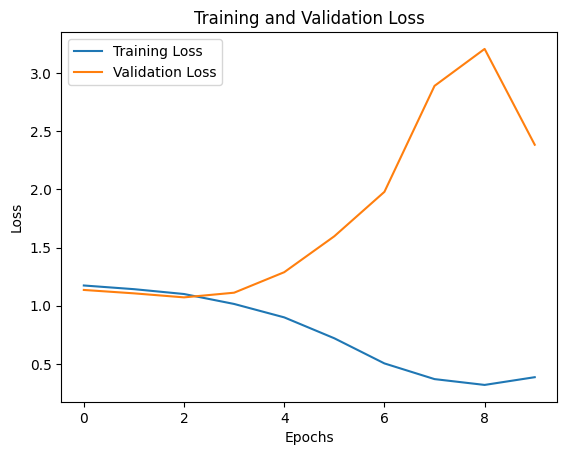

In [13]:
# 绘制训练和验证的损失值曲线
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

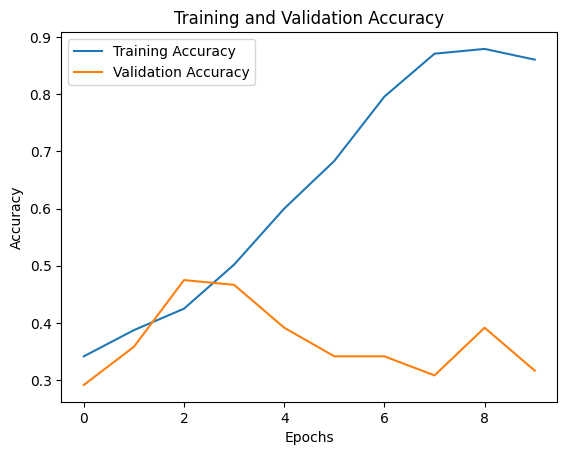

In [14]:
# 绘制训练和验证的准确率曲线
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 5. 使用数据装载器进行边读取边训练

In [90]:
def preprocess_data(sample):
    # 截取并调整每个样本为 (4, 240, 1)
    return np.transpose(sample[:, 0:4, 0:240], (1, 2, 0))

def normalize_data(data):
    # 将数据归一化到 [0, 1] 之间
    return data / 4.0

def data_generator(data_files, label_files, batch_size):
    while True:
        for start in range(0, len(data_files), batch_size):
            end = min(start + batch_size, len(data_files))
            batch_data = []
            batch_labels = []
            for i in range(start, end):
                sample = np.load(data_files[i])
                label = np.load(label_files[i])
                preprocessed_sample = preprocess_data(sample)
                normalized_sample = normalize_data(preprocessed_sample)
                batch_data.append(normalized_sample)
                batch_labels.append(label)
            yield np.array(batch_data), np.array(batch_labels)

In [91]:
data_dir = 'simulation/out/S1U-test/numpy_data/seq'
label_dir = 'simulation/out/S1U-test/numpy_data/label'

data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npy')])
label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.npy')])

# 使用 train_test_split 进行数据集划分
train_data_files, val_data_files, train_label_files, val_label_files = train_test_split(
    data_files, label_files, test_size=0.2, random_state=42)

batch_size = 32
steps_per_epoch = len(train_data_files) // batch_size
validation_steps = len(val_data_files) // batch_size

In [92]:
model = get_dl_model_240()

model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

history = model.fit(
    data_generator(train_data_files, train_label_files, batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=data_generator(val_data_files, val_label_files, batch_size),
    validation_steps=validation_steps
)

Epoch 1/10


2024-06-07 13:21:35.775854: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_11_1/dropout_45_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 183s 119ms/step - loss: 0.6287 - sparse_categorical_accuracy: 0.7171 - val_loss: 0.9395 - val_sparse_categorical_accuracy: 0.7136
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 178s 118ms/step - loss: 0.4142 - sparse_categorical_accuracy: 0.8335 - val_loss: 0.3424 - val_sparse_categorical_accuracy: 0.8587
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 178s 119ms/step - loss: 0.3855 - sparse_categorical_accuracy: 0.8416 - val_loss: 0.3140 - val_sparse_categorical_accuracy: 0.8736
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 146s 97ms/step - loss: 0.3611 - sparse_categorical_accuracy: 0.8535 - val_loss: 0.4196 - val_sparse_categorical_accuracy: 0.8066
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 85s 57ms/step - loss: 0.3407 - sparse_categorical_accuracy: 0.8616 - val_loss: 0.2871 - val_sparse_categorical_accuracy: 0.8798
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 174s 116ms/step - loss: 0.3231 - sparse_categorical_accuracy: 0.8650 - val_loss: 0.3326 - val_sparse_categorical

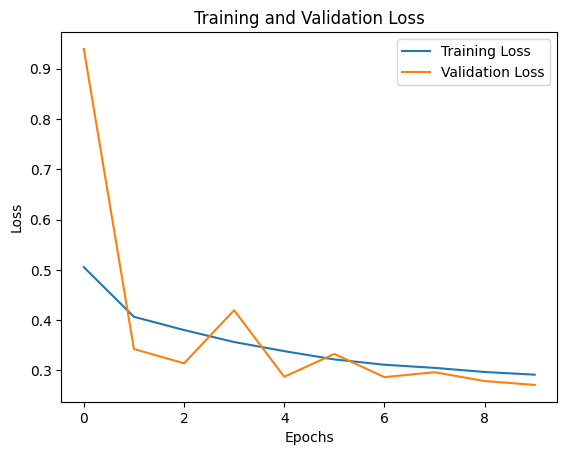

In [93]:
# 绘制训练和验证的损失值曲线
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

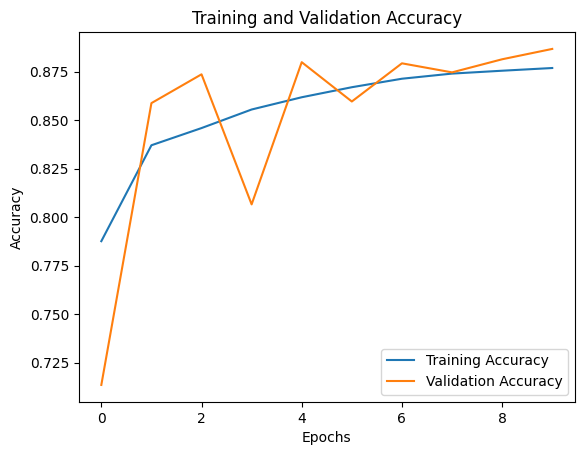

In [94]:
# 绘制训练和验证的准确率曲线
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [95]:
test_data_dir = 'simulation/out/S1U-test2/numpy_data/seq'
test_label_dir = 'simulation/out/S1U-test2/numpy_data/label'

# 评估模型在测试集上的性能
test_data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(test_data_dir) if f.endswith('.npy')])
test_label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(test_label_dir) if f.endswith('.npy')])

test_steps = len(test_data_files) // batch_size

# 评估模型
test_loss, test_accuracy = model.evaluate(
    data_generator(test_data_files, test_label_files, batch_size),
    steps=test_steps
)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1097 - sparse_categorical_accuracy: 0.9518
Test Loss: 0.12066502869129181
Test Accuracy: 0.9536290168762207


### 6. 使用滑动窗口